In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchdiffeq import odeint

from pit.dynamics.kinematic_bicycle_f110 import KinematicBicycle_Steer
from pit.integration import Euler, RK4
from pit.data_processor.csv_loader import fetch_aligned_trajectory_data

import matplotlib.pyplot as plt
import json
import math

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


## Helper Functions

In [3]:
"""
ACCELERATION

class pid:


if current_speed > 0.:
    if (vel_diff > 0):
        # accelerate
        kp = 10.0 * max_a / max_v
        accl = kp * vel_diff
    else:
        # braking
        kp = 10.0 * max_a / (-min_v)
        accl = kp * vel_diff
"""

class VelocityPID(nn.Module):
    # Assume always go one direction(current_speed>0)
    def __init__(self, max_accel, min_accel, switch_v, dt) -> None:
        super().__init__()
        self.max_accel = torch.nn.Parameter(torch.tensor(max_accel, dtype=torch.float32))
        self.min_accel = torch.nn.Parameter(torch.tensor(min_accel, dtype=torch.float32))
        self.switch_v = torch.nn.Parameter(torch.tensor(switch_v, dtype=torch.float32))
        self.dt = torch.nn.Parameter(torch.tensor(dt, dtype=torch.float32))

    def forward(self, current_speed, desired_speed):
        vel_diff = desired_speed - current_speed
        accel = vel_diff / self.dt
        accel = min(max(accel, self.min_accel), self.max_accel)

        if current_speed > self.switch_v:
            accel = accel * (self.switch_v / current_speed)


class KinematicBicycle_Steer(nn.Module):
    """
    params_index = {
        "X": 0,
        "Y": 1,
        "DELTA": 2,
        "YAW": 3,
        "V": 4,
        "STEER": 0,
        "VEL": 1
    }
    """

    def __init__(self, lwb, st_delay, accel_delay, params_index) -> None:
        super().__init__()
        self.lwb = torch.nn.Parameter(torch.tensor(lwb, dtype=torch.float32))
        self.steer_delay_time = torch.nn.Parameter(torch.tensor(st_delay, dtype=torch.float32))
        self.accel_delay_time = torch.nn.Parameter(torch.tensor(accel_delay, dtype=torch.float32))
        self.accel_max = torch.nn.Parameter(torch.tensor(10.0, dtype=torch.float32))
        self.accel_min = torch.nn.Parameter(torch.tensor(-10.0, dtype=torch.float32))
        self.steer_k = torch.nn.Parameter(torch.tensor(0.9, dtype=torch.float32))
        self.steer_b = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.speed_k = torch.nn.Parameter(torch.tensor(0.9, dtype=torch.float32))
        # Define indexes for states and control inputs
        for key, value in params_index.items():
            setattr(self, key, value)
        # real U: steer, velocity
        # model U: steer_vel, accel.

    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 5) or (5)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape) == 2 else False
        diff = torch.zeros_like(states)

        
        if batch_mode:
            steer = self.steer_k*states[:, self.DELTA] + self.steer_b
            desired_vel = control_inputs[:, self.VEL]*self.speed_k
            current_vel = states[:, self.V]
            accel = (desired_vel - current_vel) / self.accel_delay_time
            
            diff[:, self.X] = states[:, self.V] * torch.cos(states[:, self.YAW])
            diff[:, self.Y] = states[:, self.V] * torch.sin(states[:, self.YAW])
            diff[:, self.DELTA] = self.steer_k*(control_inputs[:, self.STEER] - states[:, self.DELTA]) / self.steer_delay_time
            diff[:, self.YAW] = (states[:, self.V] * torch.tan(steer)) / self.lwb
            diff[:, self.V] = torch.clamp(accel, self.accel_min, self.accel_max)
        else:
            steer = self.steer_k*states[self.DELTA] + self.steer_b
            desired_vel = control_inputs[self.VEL]*self.speed_k
            current_vel = states[self.V]
            accel = (desired_vel - current_vel) / self.accel_delay_time
            
            diff[self.X] = states[self.V] * torch.cos(states[self.YAW])
            diff[self.Y] = states[self.V] * torch.sin(states[self.YAW])
            diff[self.DELTA] = self.steer_k*(control_inputs[self.STEER] - states[self.DELTA]) / self.steer_delay_time
            # diff[YAW] = (states[V] * torch.tan(control_inputs[STEER])) / self.lwb
            diff[self.YAW] = (states[self.V] * torch.tan(steer)) / self.lwb
            diff[self.V] = torch.clamp(accel, self.accel_min, self.accel_max)
        return diff

In [ ]:
class PacejkaTireModel(nn.Module):
    def __init__(self, initial_value, params_index) -> None:
        """
        params_index = {
            "X": 0,
            "Y": 1,
            "DELTA": 2,
            "YAW": 3,
            "VX": 4,
            "VY": 5,
            "YAWRATE": 6,

            "STEER": 0,
            "VEL": 1

            "FYF": 0,
            "FYR": 1,
        }
        """
        super().__init__()
        self.lf = torch.nn.Parameter(torch.tensor(initial_value['lf'], dtype=torch.float32))
        self.lr = torch.nn.Parameter(torch.tensor(initial_value['lr'], dtype=torch.float32))
        self.Iz = torch.nn.Parameter(torch.tensor(initial_value['Iz'], dtype=torch.float32))
        self.mass = torch.nn.Parameter(torch.tensor(initial_value['mass'], dtype=torch.float32))
        self.Df = torch.nn.Parameter(torch.tensor(initial_value['Df'], dtype=torch.float32))
        self.Cf = torch.nn.Parameter(torch.tensor(initial_value['Cf'], dtype=torch.float32))
        self.Bf = torch.nn.Parameter(torch.tensor(initial_value['Bf'], dtype=torch.float32))
        self.Ef = torch.nn.Parameter(torch.tensor(initial_value['Ef'], dtype=torch.float32))
        self.Dr = torch.nn.Parameter(torch.tensor(initial_value['Dr'], dtype=torch.float32))
        self.Cr = torch.nn.Parameter(torch.tensor(initial_value['Cr'], dtype=torch.float32))
        self.Br = torch.nn.Parameter(torch.tensor(initial_value['Br'], dtype=torch.float32))
        self.Er = torch.nn.Parameter(torch.tensor(initial_value['Er'], dtype=torch.float32))
        self.mu = torch.nn.Parameter(torch.tensor(initial_value['mu'], dtype=torch.float32))

        for key, value in params_index.items():
            setattr(self, key, value)

    def forward(self, states, control_inputs):
        """ Get the tire forces at this point

        Args:
            states (): Shape of (B, 7) or (7)
            control_inputs (): Shape of (B, 2) or (2)
        Returns:
            tire_forces (): Shape of (B, 3) or (3) [Frx, Ffy, Fry]
        """
        batch_mode = True if len(states.shape)==2 else False
        device = self.mass.device
        if batch_mode:
            B = states.shape[0]
            accel
            tire_forces = torch.zeros((B, 2), device=device)
            alpha_f = states[:, self.DELTA] - torch.arctan((states[:, self.YAWRATE]*self.lf + states[:, self.VY])/states[:, self.VX])
            alpha_r = torch.arctan((states[:, self.YAW_RATE] * self.lr - states[:, self.VY])/states[:, self.VX])
            F_zf = self.mass * (self.lr * self.g - self.h * accel) / (self.lr + self.lf)
            F_zr = self.mass * (self.lf * self.g + self.h * accel) / (self.lr + self.lf)
            #         F_yf = mu * F_zf * D_f * math.sin(C_f * math.atan(B_f * alpha_f - E_f * (B_f * alpha_f - math.atan(B_f * alpha_f))))
            tire_forces[:, self.FYF] = self.mu * F_zf * self.Df * torch.sin(self.Cf * torch.arctan(self.Bf * alpha_f - self.Ef*(self.Bf * alpha_f - torch.arctan(self.Bf * alpha_f))))
            tire_forces[:, self.FYR] = self.mu * F_zr * self.Dr * torch.sin(self.Cr * torch.arctan(self.Br * alpha_r - self.Er*(self.Br * alpha_r - torch.arctan(self.Br * alpha_r))))
        else:
            tire_forces = torch.zeros(2, device=device)
            accel
            alpha_f = states[self.DELTA] - torch.arctan((states[self.YAWRATE]*self.lf + states[self.VY])/states[self.VX])
            alpha_r = torch.arctan((states[self.YAWRATE] * self.lr - states[self.VY])/states[self.VX])
            F_zf = self.mass * (self.lr * self.g - self.h * accel) / (self.lr + self.lf)
            F_zr = self.mass * (self.lf * self.g + self.h * accel) / (self.lr + self.lf)
            tire_forces[self.FYF] = self.mu * F_zf * self.Df * torch.sin(self.Cf * torch.arctan(self.Bf * alpha_f - self.Ef*(self.Bf * alpha_f - torch.arctan(self.Bf * alpha_f))))
            tire_forces[self.FYR] = self.mu * F_zr * self.Dr * torch.sin(self.Cr * torch.arctan(self.Br * alpha_r - self.Er*(self.Br * alpha_r - torch.arctan(self.Br * alpha_r))))
        return tire_forces


class DynamicBicycle_Steer(nn.Module):
    """
    OLD:
    State Variable [x, y, yaw, vx, vy, yaw rate, steering angle]
    Control Inputs [drive force, steering speed]

    NEW:
        x (numpy.ndarray (5, )): vehicle state vector
            x0: x-position in a global coordinate system
            x1: y-position in a global coordinate system
            x2: steering angle of front wheels
            x3: yaw angle
            x4: velocity in x-direction
            x5: velocity in y direction
            x6: yaw rate

        u: (numpy.ndarray (2, )) control input vector
            u0: steering angle
            u1: longitudinal acceleration
        p:
        type:

    params_index = {
        "X": 0,
        "Y": 1,
        "DELTA": 2,
        "YAW": 3,
        "VX": 4,
        "VY": 5,
        "YAWRATE": 6,

        "STEER": 0,
        "VEL": 1
    }
    """
    def __init__(self, initial_value, params_index, tire_model) -> None:
        super().__init__()
        if tire_model == "pacejka":
            self.tire_model = PacejkaTireModel(initial_value, params_index)
        for key, value in params_index.items():
            setattr(self, key, value)


    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 7) or (7)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape)==2 else False

        diff = torch.zeros_like(states)
        tire_forces = self.calculate_tire_forces(states, control_inputs)
        if batch_mode:
            diff[:, X] = states[:, self.VX] * torch.cos(states[:, self.YAW]) - states[:, self.VY] * torch.sin(states[:, self.YAW])
            diff[:, Y] = states[:, self.VX] * torch.sin(states[:, self.YAW]) - states[:, self.VY] * torch.cos(states[:, self.YAW])
            diff[:, self.DELTA] = sv
            diff[:, YAW] = states[:, self.YAWRATE]
            diff[:, self.VX] = accel
            diff[:, self.VY] = 1.0 / self.mass * (tire_forces[:, self.FRY] + tire_forces[:, self.FFY] * torch.cos(states[:, self.DELTA]) - states[:, self.VX] * states[:, self.YAW_RATE] * self.mass)
            diff[:, self.YAWRATE] = 1.0 / self.Iz * (tire_forces[:, self.FFY] * self.lf * torch.cos(states[:, self.DELTA]) - tire_forces[:, self.FRY] * self.lr)

        else:
            diff[self.X] = states[self.VX] * torch.cos(states[self.YAW]) - states[self.VY] * torch.sin(states[self.YAW])
            diff[self.Y] = states[self.VX] * torch.sin(states[self.YAW]) - states[self.VY] * torch.cos(states[self.YAW])
            diff[self.DELTA] = sv
            diff[self.YAW] = states[self.YAW_RATE]
            diff[self.VX] = accel
            diff[self.VY] = 1.0 / self.mass * (tire_forces[self.FRY] + tire_forces[self.FFY] * torch.cos(states[self.DELTA]) - states[self.VX] * states[self.YAW_RATE] * self.mass)
            diff[self.YAW_RATE] = 1.0 / self.Iz * (tire_forces[self.FFY] * self.lf * torch.cos(states[self.DELTA]) - tire_forces[self.FRY] * self.lr)

        return diff
        

In [46]:
X, Y, DELTA, YAW, V = 0, 1, 2, 3, 4
STEER, VEL = 0, 1

def plot_states(pred, gt, ti, horizon=None):
    if horizon:
        pred = pred[:horizon, :]
        gt = gt[:horizon, :]
        ti = ti[:horizon]
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(ti, pred[:, DELTA], label='pred_steer', color='blue')
    ax[0][0].plot(ti, gt[:, DELTA], label='gt_steer', color='red')
    ax[0][0].legend()
    pred[:, YAW] = (pred[:, YAW] + math.pi) % (2 * math.pi) - math.pi
    ax[0][1].plot(ti, pred[:, YAW], label='pred_yaw', color='blue')
    ax[0][1].plot(ti, gt[:, YAW], label='gt_yaw', color='red')
    ax[0][1].legend()
    ax[1][0].plot(ti, pred[:, V], label='pred_v', color='blue')
    ax[1][0].plot(ti, gt[:, V], label='gt_v', color='red')
    # ax[1][0].set_xlabel('Time')
    # ax[1][0].set_ylabel('Value')
    ax[1][0].legend()

    # Plot for XY trajectory
    ax[1][1].plot(pred[:, 0], pred[:, 1], label='Pred Trajectory', color='blue')
    ax[1][1].plot(gt[:, 0], gt[:, 1], label='GT Trajectory', color='red')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel('y')
    ax[1][1].set_title('XY Trajectory')
    ax[1][1].legend()
    ax[1][1].grid(True)

    plt.tight_layout()
    plt.show()

def batch_from_csv(traj_data, cut_off, device, step_gap=10, horizon=50):
    x = torch.tensor(traj_data['/pf/pose/odom/pose/pose/position/x'].to_numpy())[cut_off:]
    y = torch.tensor(traj_data['/pf/pose/odom/pose/pose/position/y'].to_numpy())[cut_off:]
    v = torch.tensor(traj_data['/odom/twist/twist/linear/x'].to_numpy())[cut_off:]
    yaw = torch.tensor(traj_data['/pf/pose/odom/pose/pose/orientation/yaw_deg'].to_numpy()*np.pi/180)[cut_off:]
    ti = torch.tensor(traj_data.index.to_numpy())[cut_off:]
    
    steer = torch.tensor(traj_data['/ackermann_cmd/drive/steering_angle'].to_numpy())[cut_off:]
    speed = torch.tensor(traj_data['/ackermann_cmd/drive/speed'].to_numpy())[cut_off:]
    
    initial_state = torch.tensor([x[0],y[0],steer[0],yaw[0],v[0]]).to(device)
    control_inputs = torch.vstack([steer, speed]).T
    control_inputs = control_inputs.contiguous().to(device)
    output_states = torch.vstack([x, y, steer, yaw, v]).T.to(device)
    target_states = output_states[1:]
    target_states = target_states.contiguous()

    STEP_GAP=step_gap
    HORIZON=horizon
    state_dims = initial_state.shape[0]
    input_dims = control_inputs.shape[-1]
    batch_size = (control_inputs.shape[0]-HORIZON-1)//STEP_GAP
    
    batched_timestamps = torch.zeros((batch_size, HORIZON, 1), device=DEVICE)
    batched_initial_states = torch.zeros((batch_size, state_dims), device=DEVICE)
    batched_control_inputs = torch.zeros((batch_size, HORIZON, input_dims), device=DEVICE)
    batched_target_states = torch.zeros((batch_size, HORIZON, state_dims), device=DEVICE)
    
    for step in range(batch_size):
        batched_initial_states[step] = output_states[step*STEP_GAP]
        batched_timestamps[step] = ti[:HORIZON].view(-1, 1) # Use fixed horizon for the timestamps
        # (10, 60), (20, 70), (30, 80)
        batched_control_inputs[step] = control_inputs[step*STEP_GAP:(step*STEP_GAP)+HORIZON]
        batched_target_states[step] = output_states[(step*STEP_GAP)+1:(step*STEP_GAP)+HORIZON+1]
    
    return batched_initial_states, batched_timestamps, batched_control_inputs, batched_target_states

## Load data from csv files

In [19]:
file_paths = ["../datasets/skir_1.csv", "../datasets/skir_2.csv", "../datasets/skir_3.csv"]
sample_interval = 0.04
cut_off = 50
step_gap = 5
horizon = 50

In [20]:
# Initialize lists for concatenated data
all_initial_states = []
all_timestamps = []
all_control_inputs = []
all_target_states = []
for file_path in file_paths:
    traj_data = fetch_aligned_trajectory_data(file_path, sample_interval=sample_interval)
    batched_initial_states, batched_timestamps, batched_control_inputs, batched_target_states = \
           batch_from_csv(traj_data, cut_off, DEVICE, step_gap=step_gap, horizon=horizon)
    print(f"read batch data from{file_path}, batch size{batched_initial_states.shape[0]}")
    # Append each batched tensor to its corresponding list
    all_initial_states.append(batched_initial_states)
    all_timestamps.append(batched_timestamps)
    all_control_inputs.append(batched_control_inputs)
    all_target_states.append(batched_target_states)

# Concatenate all tensors in each list along the batch dimension
concatenated_initial_states = torch.cat(all_initial_states, dim=0)
concatenated_timestamps = torch.cat(all_timestamps, dim=0)
concatenated_control_inputs = torch.cat(all_control_inputs, dim=0)
concatenated_target_states = torch.cat(all_target_states, dim=0)

read batch data from../datasets/skir_1.csv, batch size195
read batch data from../datasets/skir_2.csv, batch size113
read batch data from../datasets/skir_3.csv, batch size261


In [21]:
print(concatenated_initial_states.shape)

torch.Size([569, 5])


## Train

In [29]:
dataset = torch.utils.data.TensorDataset(concatenated_initial_states, concatenated_control_inputs, concatenated_target_states, concatenated_timestamps)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [50]:
params_index = {
    "X": 0,
    "Y": 1,
    "DELTA": 2,
    "YAW": 3,
    "V": 4,
    "STEER": 0,
    "VEL": 1
}
kinematic_f110 = KinematicBicycle_Steer(lwb=0.31, st_delay=0.05, accel_delay=0.2, params_index=params_index).to(DEVICE)
kinematic_f110.lwb.requires_grad = True
kinematic_f110.steer_delay_time.requires_grad = False
kinematic_f110.accel_delay_time.requires_grad = False
kinematic_f110.accel_max.requires_grad = False
kinematic_f110.accel_min.requires_grad = False
kinematic_f110.steer_k.requires_grad = True
kinematic_f110.steer_b.requires_grad = False
euler_integrator = Euler(kinematic_f110, timestep=sample_interval)
rk4_integrator = RK4(kinematic_f110, timestep=sample_interval)
print(sample_interval)

0.04


In [40]:
def kinematic_steer_loss(pred, target, params_index):
    X, Y, YAW, V = params_index["X"], params_index["Y"], params_index["YAW"], params_index["V"]
    indices = [X, Y, V]
    pred_selected = pred[..., indices]
    target_selected = target[..., indices]
    # NOTE: can not modify the varibale inplace, so yaw is regularized separately
    regularize_yaw =  (pred[..., YAW] + math.pi) % (2 * math.pi) - math.pi
    
    # Compute the L1 loss
    # return torch.abs(pred_selected - target_selected).mean() + torch.abs(regularize_yaw - target[..., YAW]).mean()
    return torch.abs(pred_selected - target_selected).mean()

### View trajectory data

In [ ]:
# (1) MCMC, calculate difference between two distribution(add cov term)
# (2) Stochastic ODE

In [479]:
# with torch.no_grad():
#     pred = rk4_integrator(initial_state, control_inputs)
#     val_loss = kinematic_steer_loss(pred, output_states, params_index=params_index)
#     print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

Initialized | Validation Loss: 0.601844228253825 | LR: 0.003874204890000002


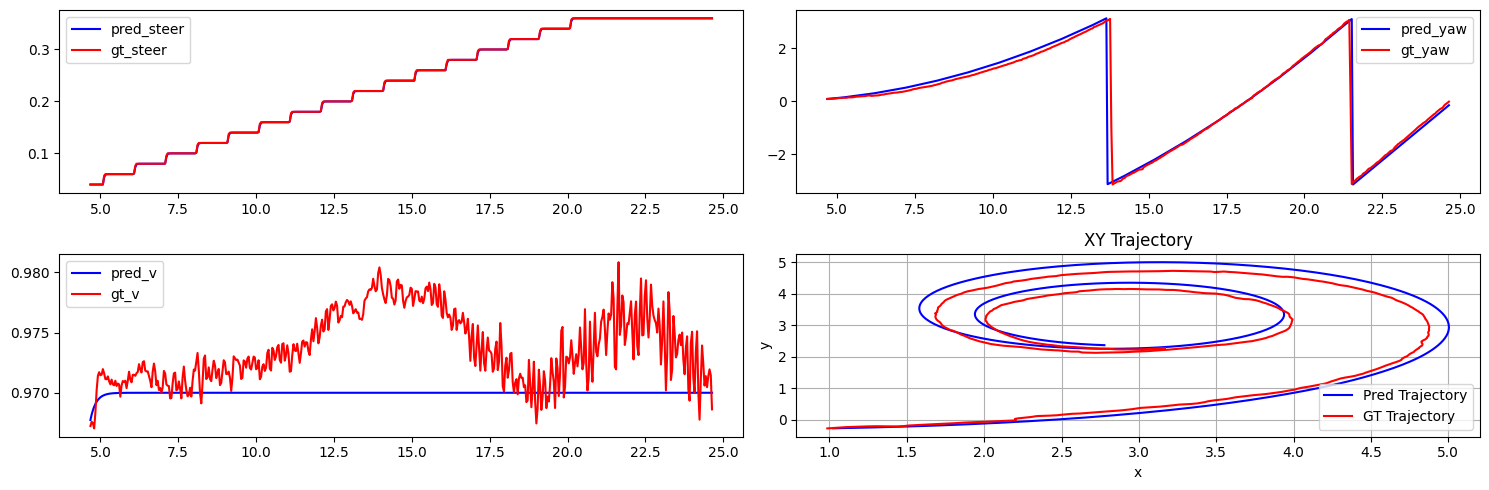

In [480]:
# plot_states(pred.cpu().detach().numpy(), output_states.cpu().detach().numpy(), ti, horizon=500)

### View batched data

torch.Size([128, 5]) torch.Size([128, 50, 2]) torch.Size([128, 50, 5]) torch.Size([128, 50, 1])
torch.Size([128, 50, 5])


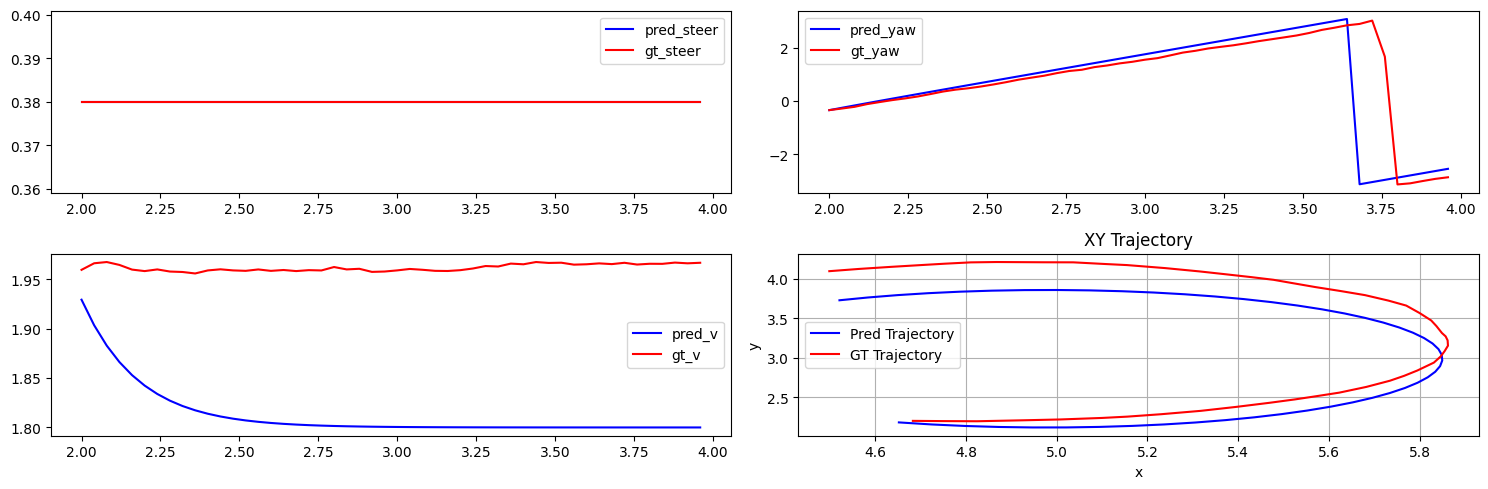

batch_loss: 0.1465476006269455


In [54]:
with torch.no_grad():
    for initial, inputs, targets, timestamps in dataloader:
        print(initial.shape, inputs.shape, targets.shape, timestamps.shape)
        # batched_traj = integrator(kinematic_f110, initial, inputs, batched_timestamps)
        batched_traj = rk4_integrator(initial, inputs)
        print(batched_traj.shape)
        plot_states(batched_traj[0].cpu().detach().numpy(), targets[0].cpu().detach().numpy(), timestamps[0].cpu().detach().numpy(), horizon=300)
        batch_loss = kinematic_steer_loss(batched_traj, targets, params_index)
        print(f"batch_loss: {batch_loss}")
        break

In [56]:
from tqdm.auto import tqdm
EPOCHS = 100
optimizer = torch.optim.SGD(kinematic_f110.parameters(), lr=0.01, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

  0%|          | 0/100 [00:00<?, ?it/s]

lwb tensor(0.2920) tensor(-0.1428)
steer_k tensor(0.9102) tensor(0.0525)
speed_k tensor(0.9814) tensor(0.1248)


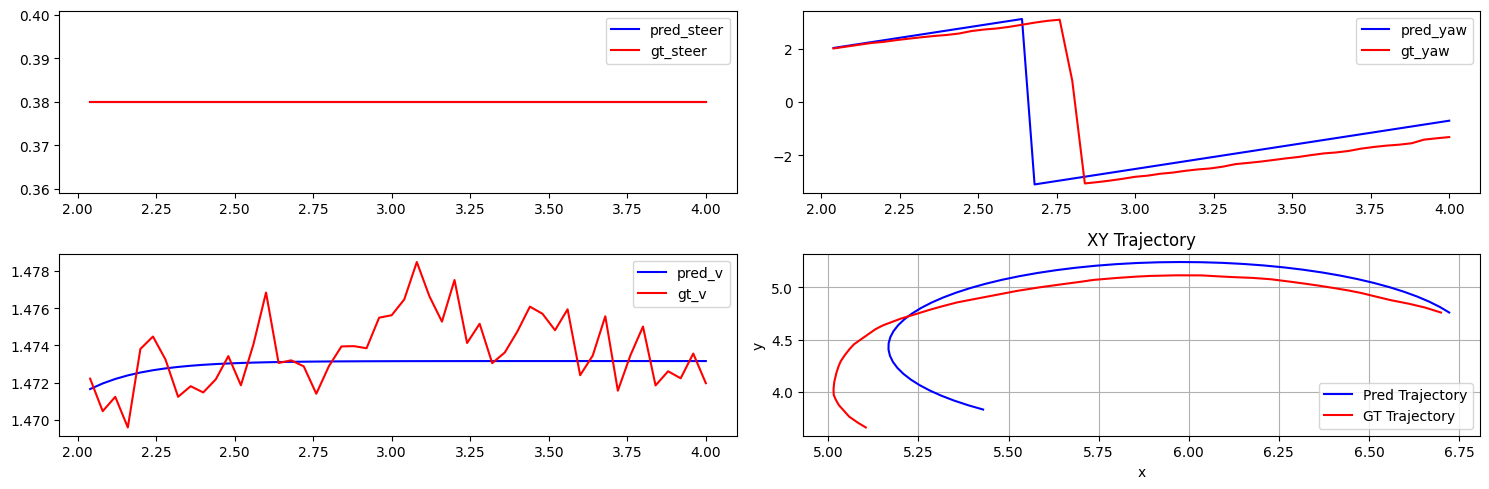

Epoch: 0 | Training Loss: 0.08256310969591141 | LR: 0.01
Epoch: 0 | Training Loss: 0.08256310969591141 | LR: 0.01
Epoch: 1 | Training Loss: 0.08771031349897385 | LR: 0.01
Epoch: 2 | Training Loss: 0.09474866837263107 | LR: 0.01
Epoch: 3 | Training Loss: 0.07735532522201538 | LR: 0.01
Epoch: 4 | Training Loss: 0.10232558846473694 | LR: 0.01
lwb tensor(0.2997) tensor(-0.4114)
steer_k tensor(0.9056) tensor(0.1445)
speed_k tensor(0.9813) tensor(-0.0668)
Epoch: 5 | Training Loss: 0.09719480574131012 | LR: 0.01
Epoch: 6 | Training Loss: 0.11797098070383072 | LR: 0.01
Epoch: 7 | Training Loss: 0.08762161433696747 | LR: 0.01
Epoch: 8 | Training Loss: 0.10078679770231247 | LR: 0.01
Epoch: 9 | Training Loss: 0.1047007143497467 | LR: 0.01
lwb tensor(0.2948) tensor(0.0853)
steer_k tensor(0.9059) tensor(-0.0276)
speed_k tensor(0.9809) tensor(-0.0931)
Epoch: 10 | Training Loss: 0.09212597459554672 | LR: 0.01
Epoch: 11 | Training Loss: 0.08854013681411743 | LR: 0.01
Epoch: 12 | Training Loss: 0.09475

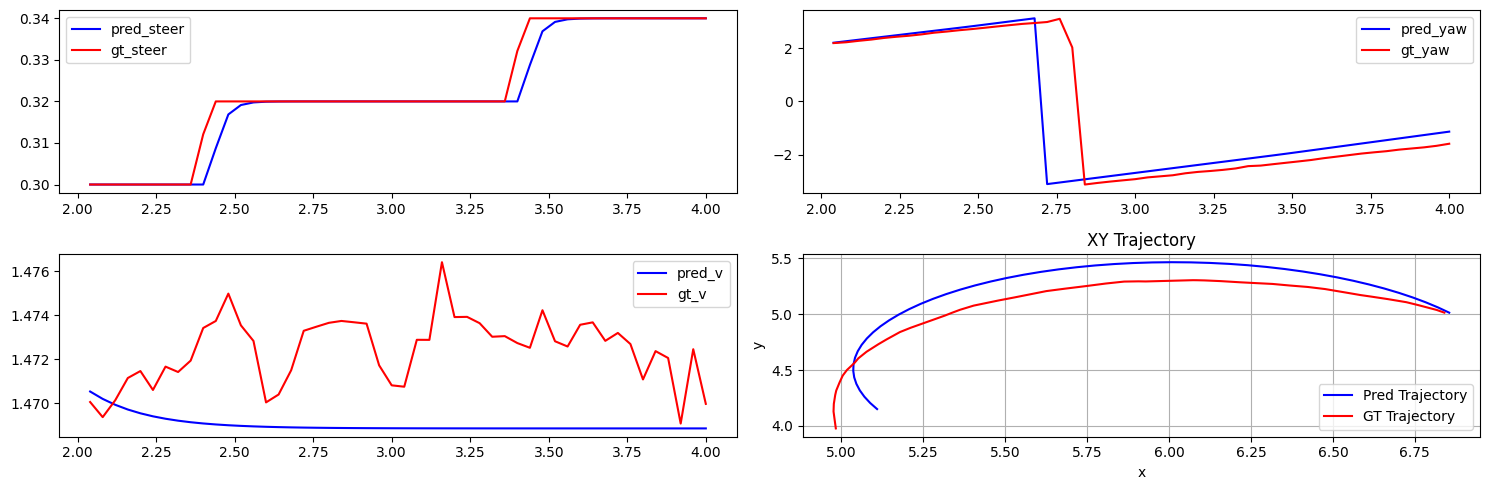

Epoch: 20 | Training Loss: 0.08187813311815262 | LR: 0.009000000000000001
Epoch: 20 | Training Loss: 0.08187813311815262 | LR: 0.009000000000000001
Epoch: 21 | Training Loss: 0.08954150229692459 | LR: 0.009000000000000001
Epoch: 22 | Training Loss: 0.07881956547498703 | LR: 0.009000000000000001
Epoch: 23 | Training Loss: 0.08842670917510986 | LR: 0.009000000000000001
Epoch: 24 | Training Loss: 0.11283671855926514 | LR: 0.009000000000000001
lwb tensor(0.2916) tensor(0.1744)
steer_k tensor(0.9006) tensor(-0.0579)
speed_k tensor(0.9815) tensor(0.0003)
Epoch: 25 | Training Loss: 0.07912507653236389 | LR: 0.009000000000000001
Epoch: 26 | Training Loss: 0.08181948214769363 | LR: 0.008100000000000001
Epoch: 27 | Training Loss: 0.08120045810937881 | LR: 0.008100000000000001
Epoch: 28 | Training Loss: 0.09528395533561707 | LR: 0.008100000000000001
Epoch: 29 | Training Loss: 0.07681505382061005 | LR: 0.008100000000000001
lwb tensor(0.2935) tensor(-0.1452)
steer_k tensor(0.8978) tensor(0.0512)
sp

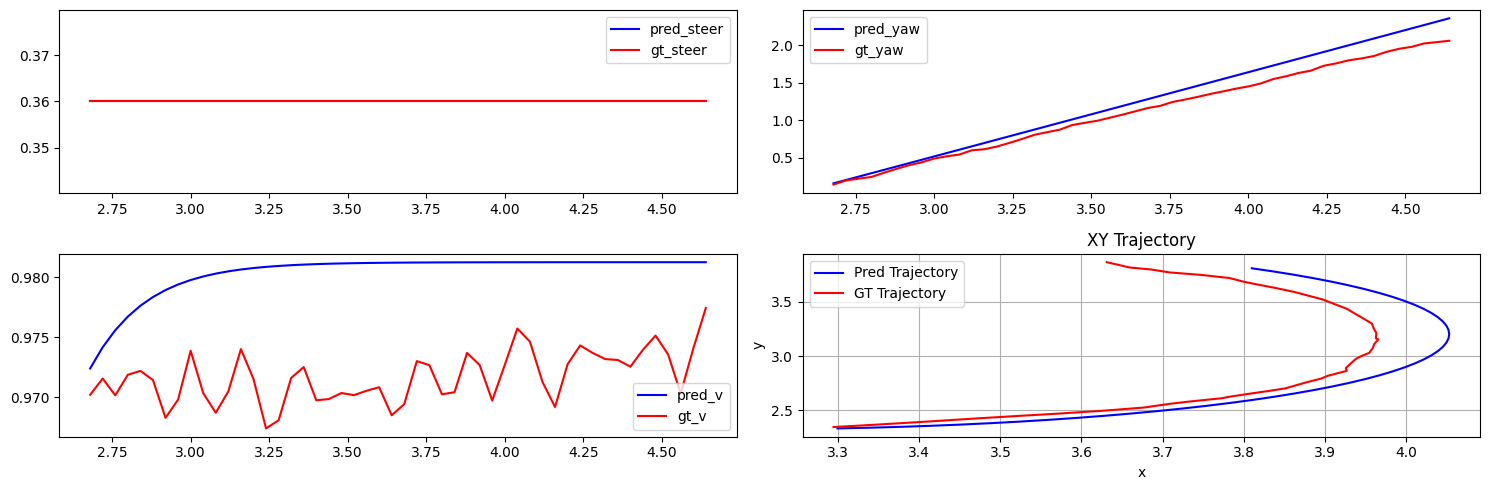

Epoch: 40 | Training Loss: 0.08590434491634369 | LR: 0.008100000000000001
Epoch: 40 | Training Loss: 0.08590434491634369 | LR: 0.008100000000000001
Epoch: 41 | Training Loss: 0.09771633893251419 | LR: 0.008100000000000001
Epoch: 42 | Training Loss: 0.08270527422428131 | LR: 0.008100000000000001
Epoch: 43 | Training Loss: 0.08679524064064026 | LR: 0.008100000000000001
Epoch: 44 | Training Loss: 0.06961720436811447 | LR: 0.007290000000000001
lwb tensor(0.2907) tensor(0.0504)
steer_k tensor(0.8936) tensor(-0.0156)
speed_k tensor(0.9804) tensor(-0.0030)
Epoch: 45 | Training Loss: 0.08351045101881027 | LR: 0.007290000000000001
Epoch: 46 | Training Loss: 0.10028931498527527 | LR: 0.007290000000000001
Epoch: 47 | Training Loss: 0.08256377279758453 | LR: 0.007290000000000001
Epoch: 48 | Training Loss: 0.08726999163627625 | LR: 0.007290000000000001
Epoch: 49 | Training Loss: 0.10149633139371872 | LR: 0.007290000000000001
lwb tensor(0.2899) tensor(-0.3440)
steer_k tensor(0.8922) tensor(0.1195)
s

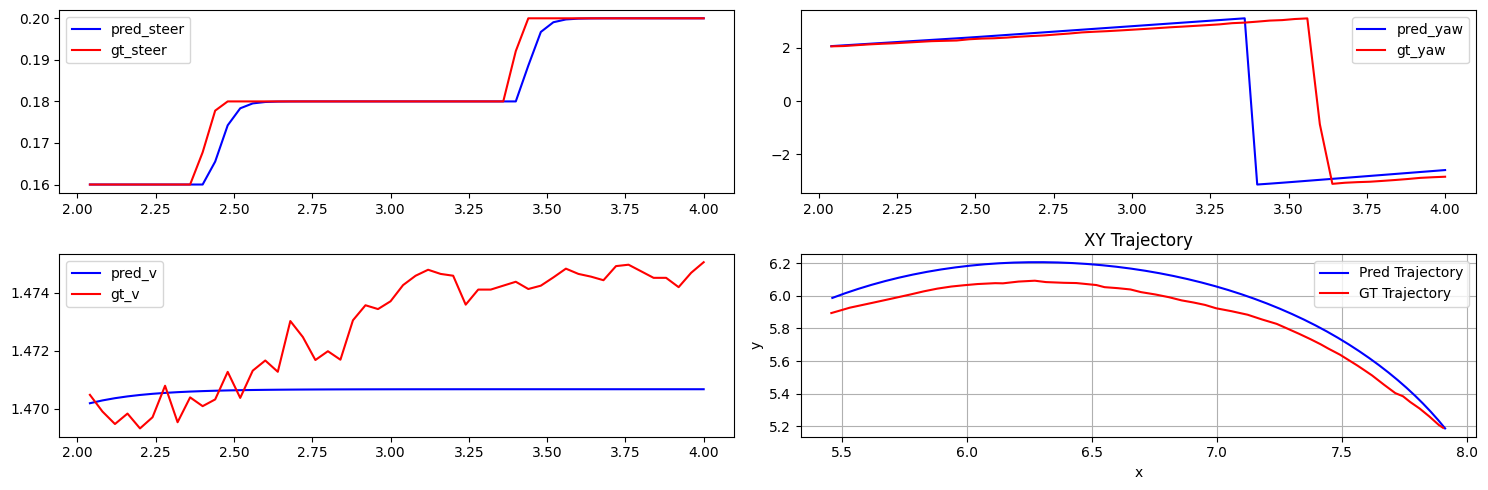

Epoch: 60 | Training Loss: 0.08122871816158295 | LR: 0.006561000000000002
Epoch: 60 | Training Loss: 0.08122871816158295 | LR: 0.006561000000000002
Epoch: 61 | Training Loss: 0.0888357013463974 | LR: 0.006561000000000002
Epoch: 62 | Training Loss: 0.11140654236078262 | LR: 0.006561000000000002
Epoch: 63 | Training Loss: 0.10004543513059616 | LR: 0.006561000000000002
Epoch: 64 | Training Loss: 0.07307762652635574 | LR: 0.006561000000000002
lwb tensor(0.2900) tensor(-0.1580)
steer_k tensor(0.8877) tensor(0.0570)
speed_k tensor(0.9803) tensor(-0.0217)
Epoch: 65 | Training Loss: 0.09064070135354996 | LR: 0.006561000000000002
Epoch: 66 | Training Loss: 0.09352534264326096 | LR: 0.006561000000000002
Epoch: 67 | Training Loss: 0.09152606129646301 | LR: 0.005904900000000002
Epoch: 68 | Training Loss: 0.07271195948123932 | LR: 0.005904900000000002
Epoch: 69 | Training Loss: 0.09407978504896164 | LR: 0.005904900000000002
lwb tensor(0.2881) tensor(-0.0669)
steer_k tensor(0.8869) tensor(0.0260)
sp

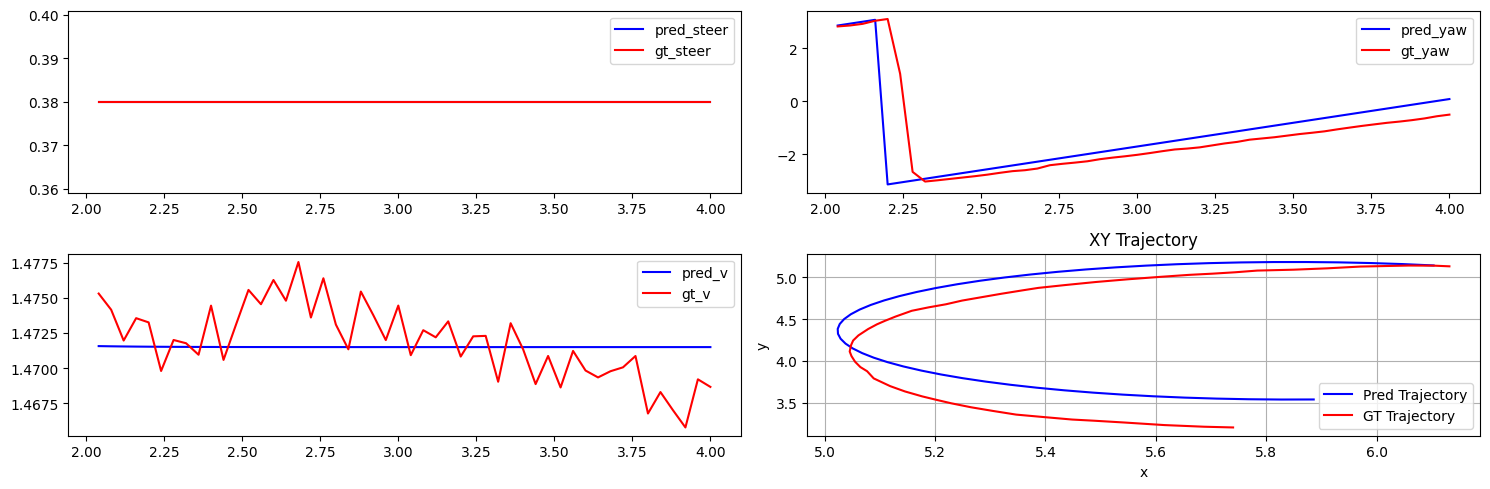

Epoch: 80 | Training Loss: 0.11555532366037369 | LR: 0.005314410000000002
Epoch: 80 | Training Loss: 0.11555532366037369 | LR: 0.005314410000000002
Epoch: 81 | Training Loss: 0.08617506921291351 | LR: 0.005314410000000002
Epoch: 82 | Training Loss: 0.07603812962770462 | LR: 0.005314410000000002
Epoch: 83 | Training Loss: 0.09729098528623581 | LR: 0.005314410000000002
Epoch: 84 | Training Loss: 0.09948799759149551 | LR: 0.005314410000000002
lwb tensor(0.2855) tensor(-0.1189)
steer_k tensor(0.8837) tensor(0.0423)
speed_k tensor(0.9810) tensor(-0.0374)
Epoch: 85 | Training Loss: 0.09424501657485962 | LR: 0.005314410000000002
Epoch: 86 | Training Loss: 0.11933162808418274 | LR: 0.005314410000000002
Epoch: 87 | Training Loss: 0.09465443342924118 | LR: 0.005314410000000002
Epoch: 88 | Training Loss: 0.08791004866361618 | LR: 0.005314410000000002
Epoch: 89 | Training Loss: 0.07290302217006683 | LR: 0.004782969000000002
lwb tensor(0.2860) tensor(-0.0150)
steer_k tensor(0.8823) tensor(0.0079)
s

In [61]:
losses = list()
lrs = list()
# torch.autograd.set_detect_anomaly(False)
for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets, timestamps in dataloader:
        optimizer.zero_grad()
        pred_states = rk4_integrator(initial, inputs)
        loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        loss.backward()
        optimizer.step()
    if i%5 == 0:
        for name, param in kinematic_f110.named_parameters():
           if param.requires_grad:
               print(name, param.data, param.grad)
    if i%20 == 0:
        plot_states(pred_states[0].cpu().detach().numpy(), targets[0].cpu().detach().numpy(), timestamps[0])
        print(f"Epoch: {i} | Training Loss: {loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    # with torch.no_grad():
    #     output_states = integrator(batched_initial_states,batched_control_inputs)
    #     val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
    #     losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    # scheduler.step(val_loss)
    scheduler.step(loss.item())


In [ ]:
# def integrator(dynamic_model, initial_states, control_inputs, ti):
#     """
#     Take batch data as input
#     """
#     def u_func(t):
#         t_interval = (t-ti[0]).item()
#         u_idx = int(t_interval/sample_interval)
#         return control_inputs[:, u_idx, :]
#     func = lambda t, x: dynamic_model(x, u_func(t))
#     # odeint give output of shape(horizon, bs, dim), so do a permute here
#     trajectory = odeint(func, initial_states, ti).permute(1, 0, 2)

#     return trajectory

# def oneD_integrator(dynamic_model, initial_states, control_inputs, ti):
#     def u_func(t):
#         t_interval = (t-ti[0]).item()
#         u_idx = int(t_interval/sample_interval)
#         return control_inputs[u_idx, :]
#     func = lambda t, x: dynamic_model(x, u_func(t))
#     trajectory = odeint(func, initial_states, ti)

#     return trajectory